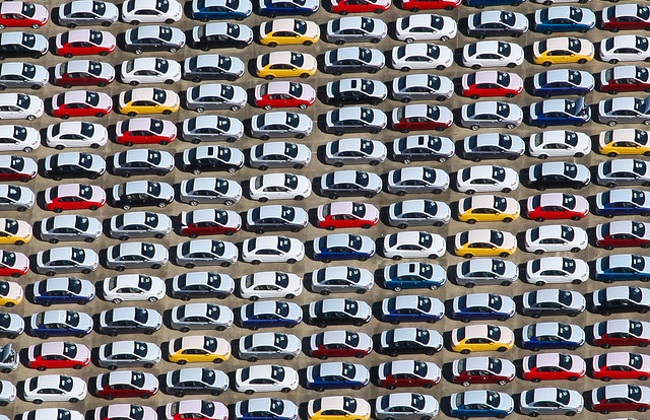

Автомобильный рынок в США всегда был индикатором экономического здоровья страны, где на автомобилях ездят практически все – от детишек до старушек. Автомобиль для американца – это в какой-то степени часть его самого, ведь без этого транспортного средства в такой огромной стране, где далеко не везде ходит общественный транспорт, зачастую просто не выжить.

В мои руки попал набор данных по продажам на авто рынках Америки. В своей работе я бы хотел провести анализ этой информации и выявить на их основе некоторые тенденции.

In [1]:
#Импортирую библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fuzzywuzzy
from fuzzywuzzy import process
import scipy
from scipy import stats
from scipy.stats import linregress

%matplotlib inline

In [2]:
def replace_matches_in_column(df, column, string_to_match, min_ratio):
    """Функция для очистки качественных данных. 
  
    """
 
    strings = df[column].unique()
    
   
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

   
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    
    rows_with_matches = df[column].isin(close_matches)

    
    df.loc[rows_with_matches, column] = string_to_match
   


In [3]:
data = pd.read_csv(r'../Датасеты/car_prices.csv',nrows=400000)

In [4]:
data.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [5]:
data.shape

(400000, 16)

In [6]:
data.describe()

,year,condition,odometer,mmr,sellingprice
count,400000.000000,388207.000000,399914.000000,400000.000000,400000.000000
mean,2009.796108,3.410007,70519.600534,13323.868750,13187.522913
std,4.042418,0.961237,54530.181852,9383.886206,9472.330671
min,1982.000000,1.000000,1.000000,25.000000,1.000000
25%,2007.000000,2.700000,28894.000000,6550.000000,6300.000000
50%,2011.000000,3.600000,54863.000000,12000.000000,11900.000000
75%,2013.000000,4.200000,102903.750000,17850.000000,17800.000000
max,2015.000000,5.000000,999999.000000,176000.000000,230000.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          400000 non-null  int64  
 1   make          392910 non-null  object 
 2   model         392844 non-null  object 
 3   trim          392581 non-null  object 
 4   body          390037 non-null  object 
 5   transmission  355878 non-null  object 
 6   vin           400000 non-null  object 
 7   state         400000 non-null  object 
 8   condition     388207 non-null  float64
 9   odometer      399914 non-null  float64
 10  color         399447 non-null  object 
 11  interior      399447 non-null  object 
 12  seller        400000 non-null  object 
 13  mmr           400000 non-null  int64  
 14  sellingprice  400000 non-null  int64  
 15  saledate      400000 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 48.8+ MB


Неправильный тип у даты. Чуть попозже поменяю его

In [8]:
data.isnull().sum()

year                0
make             7090
model            7156
trim             7419
body             9963
transmission    44122
vin                 0
state               0
condition       11793
odometer           86
color             553
interior          553
seller              0
mmr                 0
sellingprice        0
saledate            0
dtype: int64

Довольно много пропущенных значений. Заменю нуллы качественных данных на 'N', а количественных на 0

In [9]:
#Заполняю 0
data_int = data.loc[:,['condition', 'odometer', 'mmr', 'sellingprice']].fillna(0)

In [10]:
data_int.isnull().sum()

condition       0
odometer        0
mmr             0
sellingprice    0
dtype: int64

In [11]:
#Заполняю "N"
data_str = data.loc[:,['year', 'make', 'model', 'trim', 'body', 'transmission','vin', 'state', 'color', 'interior', 'seller', 'saledate']].fillna('N')

In [12]:
data_str.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
color           0
interior        0
seller          0
saledate        0
dtype: int64

In [13]:
#Объединяю
data1 = pd.concat([data_str, data_int], axis = 1)

In [14]:
data1.head()

,year,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate,condition,odometer,mmr,sellingprice
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,white,black,"kia motors america, inc",Tue Dec 16 2014 12:30:00 GMT-0800 (PST),5.0,16639.0,20500,21500
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,white,beige,"kia motors america, inc",Tue Dec 16 2014 12:30:00 GMT-0800 (PST),5.0,9393.0,20800,21500
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,gray,black,financial services remarketing (lease),Thu Jan 15 2015 04:30:00 GMT-0800 (PST),4.5,1331.0,31900,30000
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,white,black,volvo na rep/world omni,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),4.1,14282.0,27500,27750
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,gray,black,financial services remarketing (lease),Thu Dec 18 2014 12:30:00 GMT-0800 (PST),4.3,2641.0,66000,67000


In [15]:
data1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          400000 non-null  int64  
 1   make          400000 non-null  object 
 2   model         400000 non-null  object 
 3   trim          400000 non-null  object 
 4   body          400000 non-null  object 
 5   transmission  400000 non-null  object 
 6   vin           400000 non-null  object 
 7   state         400000 non-null  object 
 8   color         400000 non-null  object 
 9   interior      400000 non-null  object 
 10  seller        400000 non-null  object 
 11  saledate      400000 non-null  object 
 12  condition     400000 non-null  float64
 13  odometer      400000 non-null  float64
 14  mmr           400000 non-null  int64  
 15  sellingprice  400000 non-null  int64  
dtypes: float64(2), int64(3), object(11)
memory usage: 48.8+ MB


In [16]:
#Меняю формат даты на нужный
data1['date_parsed'] = pd.to_datetime(data1['saledate'], format = '%m/%d/%y',infer_datetime_format=True)

In [17]:
data1.head()

,year,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate,condition,odometer,mmr,sellingprice,date_parsed
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,white,black,"kia motors america, inc",Tue Dec 16 2014 12:30:00 GMT-0800 (PST),5.0,16639.0,20500,21500,2014-12-16 12:30:00+08:00
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,white,beige,"kia motors america, inc",Tue Dec 16 2014 12:30:00 GMT-0800 (PST),5.0,9393.0,20800,21500,2014-12-16 12:30:00+08:00
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,gray,black,financial services remarketing (lease),Thu Jan 15 2015 04:30:00 GMT-0800 (PST),4.5,1331.0,31900,30000,2015-01-15 04:30:00+08:00
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,white,black,volvo na rep/world omni,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),4.1,14282.0,27500,27750,2015-01-29 04:30:00+08:00
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,gray,black,financial services remarketing (lease),Thu Dec 18 2014 12:30:00 GMT-0800 (PST),4.3,2641.0,66000,67000,2014-12-18 12:30:00+08:00


In [18]:
data1.make.unique()

array(['Kia', 'BMW', 'Volvo', 'Nissan', 'Chevrolet', 'Audi', 'Ford',
       'Hyundai', 'Buick', 'Cadillac', 'Acura', 'Lexus', 'Infiniti',
       'Jeep', 'Mercedes-Benz', 'Mitsubishi', 'Mazda', 'MINI',
       'Land Rover', 'Lincoln', 'lincoln', 'Jaguar', 'Volkswagen',
       'Toyota', 'Subaru', 'Scion', 'Porsche', 'N', 'bmw', 'Dodge',
       'FIAT', 'Chrysler', 'ford', 'Ferrari', 'Honda', 'GMC',
       'mitsubishi', 'Ram', 'smart', 'chevrolet', 'Bentley', 'chrysler',
       'pontiac', 'Pontiac', 'Saturn', 'Maserati', 'Mercury', 'HUMMER',
       'landrover', 'cadillac', 'land rover', 'mercedes', 'mazda',
       'toyota', 'lexus', 'gmc truck', 'honda', 'nissan', 'porsche',
       'Saab', 'Suzuki', 'dodge', 'subaru', 'Oldsmobile', 'oldsmobile',
       'hyundai', 'jeep', 'Isuzu', 'dodge tk', 'Geo', 'acura',
       'volkswagen', 'suzuki', 'kia', 'audi', 'Rolls-Royce', 'gmc',
       'maserati', 'mazda tk', 'mercury', 'buick', 'hyundai tk',
       'mercedes-b', 'vw', 'Daewoo', 'chev truck', 'f

В колонке "make" довольно много дубликатов. Нужно это исправить

In [19]:
data1.make = data1.make.str.lower()

In [20]:
replace_matches_in_column(df = data1, column = 'make', string_to_match = 'gmc',min_ratio = 50)
replace_matches_in_column(df = data1, column = 'make', string_to_match = 'mercedes',min_ratio = 76)
replace_matches_in_column(df = data1, column = 'make', string_to_match = 'dodge',min_ratio = 77)
replace_matches_in_column(df = data1, column = 'make', string_to_match = 'ford',min_ratio = 57)
replace_matches_in_column(df = data1, column = 'make', string_to_match = 'hyundai',min_ratio = 82 )
replace_matches_in_column(df = data1, column = 'make', string_to_match = 'land rover',min_ratio =95 )
replace_matches_in_column(df = data1, column = 'make', string_to_match = 'mazda',min_ratio = 77)


In [21]:
data1.loc[data1['make']=='vw', 'make'] = 'volkswagen'
data1.loc[data1['make']=='chev truck', 'make'] = 'chevrolet'

In [22]:
#Все получлиось
data1.make.unique()

array(['kia', 'bmw', 'volvo', 'nissan', 'chevrolet', 'audi', 'ford',
       'hyundai', 'buick', 'cadillac', 'acura', 'lexus', 'infiniti',
       'jeep', 'mercedes', 'mitsubishi', 'mazda', 'mini', 'land rover',
       'lincoln', 'jaguar', 'volkswagen', 'toyota', 'subaru', 'scion',
       'porsche', 'n', 'dodge', 'fiat', 'chrysler', 'ferrari', 'honda',
       'gmc', 'ram', 'smart', 'bentley', 'pontiac', 'saturn', 'maserati',
       'mercury', 'hummer', 'saab', 'suzuki', 'oldsmobile', 'isuzu',
       'geo', 'rolls-royce', 'daewoo', 'plymouth', 'tesla', 'airstream',
       'dot', 'aston martin', 'fisker', 'lamborghini'], dtype=object)

In [23]:
#Смотрю есть ли ошибки в цветах
data1.color.unique()

array(['white', 'gray', 'black', 'red', 'silver', 'blue', 'brown',
       'beige', 'purple', 'burgundy', '—', 'gold', 'yellow', 'green',
       'charcoal', 'N', 'orange', 'off-white', 'turquoise', 'pink',
       'lime'], dtype=object)

В колонке "color" есть пропуск, поменяю его на 'N'

In [24]:
data1.loc[data1['color']=='—', 'color'] = 'N'

In [25]:
#Все получилось
data1.color.unique()

array(['white', 'gray', 'black', 'red', 'silver', 'blue', 'brown',
       'beige', 'purple', 'burgundy', 'N', 'gold', 'yellow', 'green',
       'charcoal', 'orange', 'off-white', 'turquoise', 'pink', 'lime'],
      dtype=object)

Данные очищены. Теперь я хочу приступить к визуализации

In [26]:
#Создаю дф, в котором группирую по марке авто и подсчитываю количество продаж
popular_marks = data1[data1['make']!='N'].groupby(['make'],as_index = False).condition.count()
popular_marks = popular_marks.rename(columns = {'make':'model', 'condition':'count'})

In [27]:
len(popular_marks.model.unique())


55

In [28]:
popular_marks.model.unique()

array(['acura', 'airstream', 'aston martin', 'audi', 'bentley', 'bmw',
       'buick', 'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge',
       'dot', 'ferrari', 'fiat', 'fisker', 'ford', 'geo', 'gmc', 'honda',
       'hummer', 'hyundai', 'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia',
       'lamborghini', 'land rover', 'lexus', 'lincoln', 'maserati',
       'mazda', 'mercedes', 'mercury', 'mini', 'mitsubishi', 'n',
       'nissan', 'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'ram',
       'rolls-royce', 'saab', 'saturn', 'scion', 'smart', 'subaru',
       'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [29]:
#Сортирую по количеству продаж в порядке убывания. Оставляю 10 самых продаваемых марок
most_popular_marks = popular_marks.sort_values(by='count',ascending = False).iloc[0:10,:]

In [30]:
#Переименовываю индексы
most_popular_marks.rename(index = {16:1,8:2,38:3,52:4,11:5,19:6,21:7,5:8,26:9,9:10})

,model,count
1,ford,67909
2,chevrolet,44283
3,nissan,37294
4,toyota,27821
5,dodge,22654
6,honda,20774
7,hyundai,15333
8,bmw,14367
9,kia,12873
10,chrysler,12667


In [31]:
#Создаю дф, в котором группирую по цвету и подсчитываю количество продаж
popular_color = data1[data1['color']!='N'].groupby(['color'],as_index = False).condition.count()
popular_color = popular_color.rename(columns = {'condition':'count'})

In [32]:
popular_color.head()

,color,count
0,beige,6820
1,black,79024
2,blue,36835
3,brown,4625
4,burgundy,6624


In [33]:
popular_color.loc[popular_color['count']=='N', 'count'] = 0

In [34]:
#Выбираю 10 самых популярных цветов
most_popular_colors = popular_color.sort_values(by='count',ascending = False).iloc[0:10,:]

In [35]:
most_popular_colors

,color,count
1,black,79024
17,white,75319
15,silver,59989
7,gray,59072
2,blue,36835
14,red,30997
6,gold,8735
8,green,8583
0,beige,6820
4,burgundy,6624


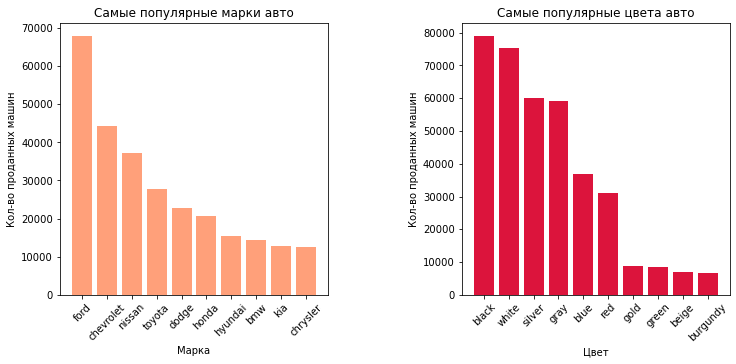

In [36]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

ax1 = plt.subplot(1, 2, 1)
plt.bar(most_popular_marks['model'], most_popular_marks['count'], color = 'lightsalmon')
plt.xticks(rotation=45)
plt.title(r'Самые популярные марки авто')
plt.xlabel('Марка')
plt.ylabel('Кол-во проданных машин')



ax2 = plt.subplot(1, 2, 2)
plt.bar(most_popular_colors['color'], most_popular_colors['count'], color = 'crimson')
plt.xticks(rotation=45)
plt.title(r'Самые популярные цвета авто')
plt.xlabel('Цвет')
plt.ylabel('Кол-во проданных машин')

plt.subplots_adjust(wspace=0.5)

Американцы довольно патриотичны и часто отдают предпочтение отечественных производителям. Также они любят японские и европейские марки. Цвета выбирают довольно стандартные, но многие делают выбор в пользу уникальности и покупают, например, золотые машины.

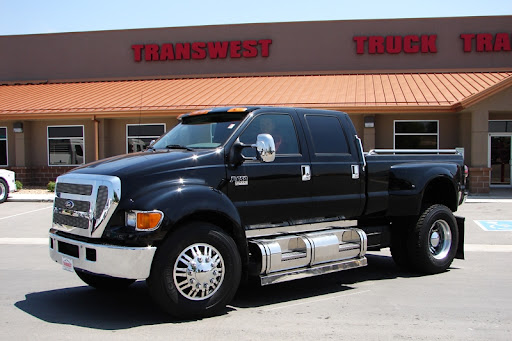

Теперь я хочу добавить расшифровку штатов. Нашел нужные данные в интернете

In [37]:
states = pd.read_excel(r'../Датасеты/states.xlsx')

In [38]:
states.head()

,Name,code,Name.1
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,Idaho,ID,Idaho
3,Iowa,IA,Iowa
4,Alabama,AL,Alabama


In [39]:
states = states.dropna()
del states['Name']

In [40]:
states = states.rename(columns = {'Name.1':'state_name'})
states['code'] = states['code'].str.lower()

In [41]:
states.head()

,code,state_name
2,id,Idaho
3,ia,Iowa
4,al,Alabama
5,ak,Alaska
6,az,Arizona


In [42]:
states.state_name.unique()

array(['Idaho', 'Iowa', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'Wyoming', ' Washington', ' Vermont', ' lth of Virginia',
       ' Wisconsin', ' Hawai`i', ' Delaware', ' Georgia',
       ' West Virginia', ' Illinois', ' Indiana', ' California',
       ' Kansas', ' lth of Kentucky', ' Colorado', ' Connecticut',
       ' Louisiana', ' lth of Massachusetts', ' Minnesota',
       ' Mississippi', ' Missouri', ' Michigan', ' Montana', ' Maine',
       ' Maryland', ' Nebraska', ' Nevada', ' New Hampshire',
       ' New Jersey', ' New York', ' New Mexico', ' Ohio', ' Oklahoma',
       ' Oregon', ' lth of Pennsylvania',
       ' Rhode Island and Providence Plantations', ' North Dakota',
       ' North Carolina', ' Tennessee', ' Texas', ' Florida',
       ' South Dakota', ' South Carolina', ' Utah'], dtype=object)

In [43]:
#Переименовываю, чтобы выглядело красивее на графике
states.loc[45,'state_name'] = 'Pennsylvania'
states.loc[22,'state_name'] = 'Kentucky'
states.loc[11,'state_name'] = 'Virginia'
states.loc[27,'state_name'] = 'Massachusetts'



In [44]:
#Соединяю с основными данными 
data1 = data1.merge(states, left_on = 'state', right_on = 'code',how = 'left')

In [45]:
data1.head()

,year,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate,condition,odometer,mmr,sellingprice,date_parsed,code,state_name
0,2015,kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,white,black,"kia motors america, inc",Tue Dec 16 2014 12:30:00 GMT-0800 (PST),5.0,16639.0,20500,21500,2014-12-16 12:30:00+08:00,ca,California
1,2015,kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,white,beige,"kia motors america, inc",Tue Dec 16 2014 12:30:00 GMT-0800 (PST),5.0,9393.0,20800,21500,2014-12-16 12:30:00+08:00,ca,California
2,2014,bmw,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,gray,black,financial services remarketing (lease),Thu Jan 15 2015 04:30:00 GMT-0800 (PST),4.5,1331.0,31900,30000,2015-01-15 04:30:00+08:00,ca,California
3,2015,volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,white,black,volvo na rep/world omni,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),4.1,14282.0,27500,27750,2015-01-29 04:30:00+08:00,ca,California
4,2014,bmw,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,gray,black,financial services remarketing (lease),Thu Dec 18 2014 12:30:00 GMT-0800 (PST),4.3,2641.0,66000,67000,2014-12-18 12:30:00+08:00,ca,California


In [46]:
data1 = data1.rename(columns = {'state_name_y':'state_name'})

In [47]:
data1['state_name'] = data1.state_name.fillna('N')
del data1['code']

In [48]:
#Проверяю пропущенные значния
data1.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
color           0
interior        0
seller          0
saledate        0
condition       0
odometer        0
mmr             0
sellingprice    0
date_parsed     0
state_name      0
dtype: int64

Все получилось. Теперь хочу создать график, на котором будет видно, в каких штатах совершается болшьше всего продаж.

In [49]:
#Создаю дф, в котором группирую по названию штата и считаю продажи
popular_state = data1[data1['state_name']!='N'].groupby(['state_name'],as_index = False).condition.count()
popular_state = popular_state.rename(columns = {'condition':'count'})

In [50]:
#Выбираю 10 штатов с самыми большими продажами
popular_state = popular_state.sort_values(by='count',ascending = False).iloc[0:10,:]

In [51]:
popular_state

,state_name,count
2,Florida,57383
0,California,56290
31,Pennsylvania,35842
24,Texas,32485
3,Georgia,24392
15,New Jersey,19177
18,North Carolina,17142
23,Tennessee,16538
5,Illinois,16504
19,Ohio,15346


Text(0, 0.5, 'Кол-во проданных машин')

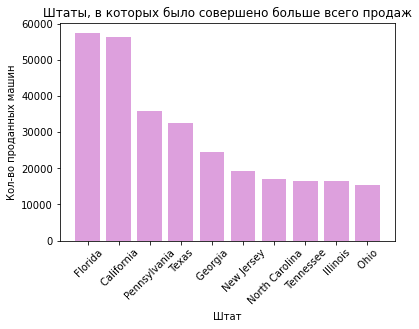

In [52]:
#Визуализирую
plt.bar(popular_state['state_name'], height =  popular_state['count'], color = 'plum' )
plt.xticks(rotation=45)
plt.title(r'Штаты, в которых было совершено больше всего продаж')
plt.xlabel('Штат')
plt.ylabel('Кол-во проданных машин')


Больше всего машин было продано во Флориде, Калифорнии и Пенсильвании. Замыкают десятку Огайо, Иллинойс и Теннесси.

Мне стало интересно различаются ли предпочтения к маркам у людей в разных штатах. Для этого я напишу небольшую функцию. Для примера я возьму Техас и Калифорнию

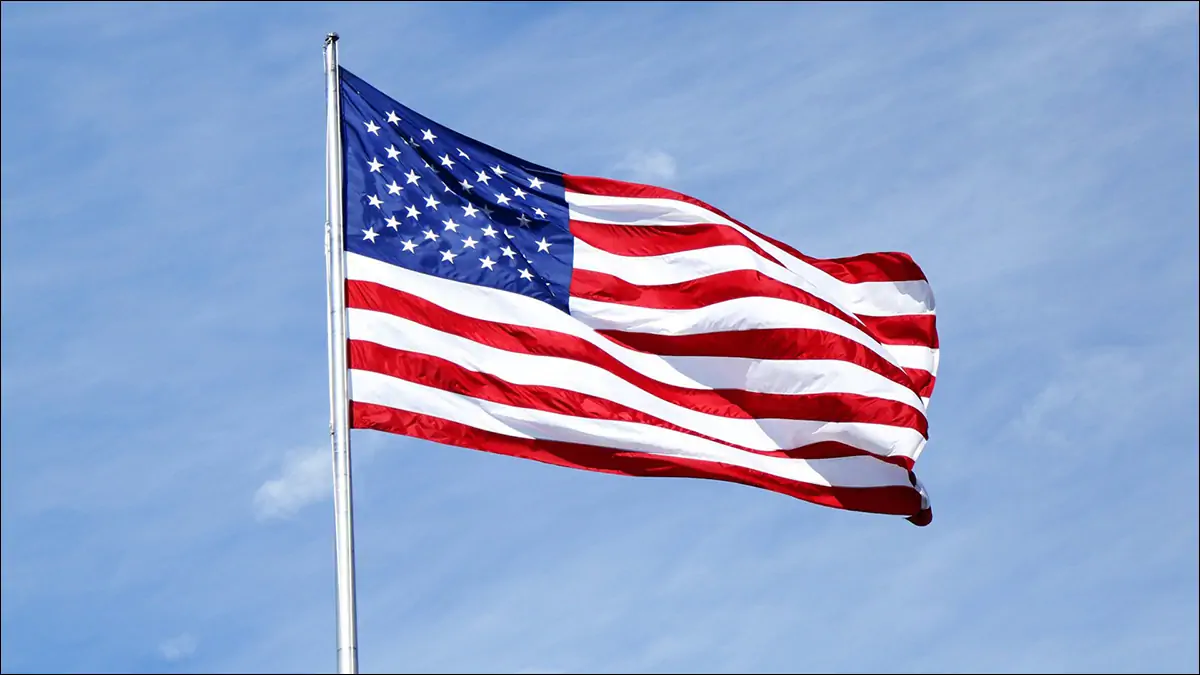

In [53]:
def marks_state(state1, state2):
    first_state = data1[data1['state_name'] == state1].groupby(['make'],as_index = False).condition.count()
    first_state = first_state.rename(columns = {'condition':'count'})
    first_state = first_state.sort_values(by='count',ascending = False).iloc[0:10,:]
    
    second_state = data1[data1['state_name'] == state2].groupby(['make'],as_index = False).condition.count()
    second_state = second_state.rename(columns = {'condition':'count'})
    second_state = second_state.sort_values(by='count',ascending = False).iloc[0:10,:]
    
    fig = plt.figure()

    fig.set_figheight(5)
    fig.set_figwidth(12)
    
    ax1 = plt.subplot(1, 2, 1)
    plt.bar(first_state['make'], first_state['count'], color = 'tan')
    plt.xticks(rotation=90)
    plt.title(f'Самые продаваемые машины в{state1}',fontsize = 12)


    ax2 = plt.subplot(1, 2, 2)
    plt.bar(second_state['make'], second_state['count'], color = 'seagreen')
    plt.xticks(rotation=90)
    plt.title(f'Самые продаваемые машины в{state2}',fontsize = 12)


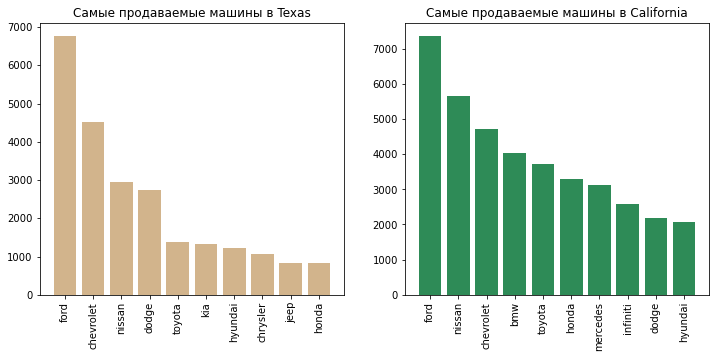

In [54]:
marks_state(' Texas', ' California')

Предпочтения действительно меняются. В Калифорнии люди гораздо чаще отдают предпочтение премиальным маркам, таким как мерседес, бмв, инфинити. В Техасе же люди предпочитают им более дешевые авто. Однако и там, и там люди любят отечественных производителей 

Теперь я хочу заняться изучением количественных данных.

In [55]:
#Создаю новый ДФ с количественными переменными
quantitative = data.loc[:,['year', 'odometer', 'condition', 'sellingprice']]

In [56]:
#Удаляю пустые значения
quantitative = quantitative.dropna(axis = 0)

In [57]:
quantitative.describe()

,year,odometer,condition,sellingprice
count,388186.000000,388186.000000,388186.000000,388186.000000
mean,2009.923369,69091.691292,3.410063,13390.215234
std,3.968544,53784.142191,0.961212,9469.978220
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,28400.000000,2.700000,6700.000000
50%,2011.000000,53310.000000,3.600000,12000.000000
75%,2013.000000,100529.750000,4.200000,18000.000000
max,2015.000000,999999.000000,5.000000,230000.000000


In [58]:
quantitative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388186 entries, 0 to 399999
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          388186 non-null  int64  
 1   odometer      388186 non-null  float64
 2   condition     388186 non-null  float64
 3   sellingprice  388186 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 14.8 MB


С типами данных все хорошо

<Figure size 864x360 with 0 Axes>

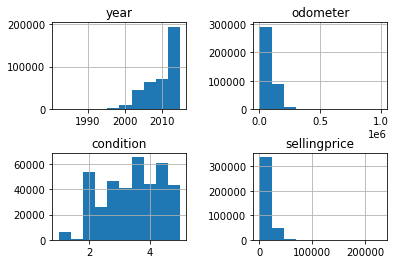

In [59]:
#Визаулизирую нормальность распределения данных
fig = plt.figure()

fig.set_figheight(5)
fig.set_figwidth(12)
quantitative.hist()
plt.subplots_adjust(wspace=0.5, hspace = 0.5)

Видно, что данные отдалены от нормального распределения. Нужно это исправить для дальнейшей работы с ними.

In [60]:
#Удаляю выбросы
quantitative = quantitative[(np.abs(stats.zscore(quantitative)) < 3).all(axis=1)]

In [61]:
quantitative.describe()

,year,odometer,condition,sellingprice
count,376101.000000,376101.000000,376101.000000,376101.000000
mean,2010.093387,66910.138325,3.424002,13119.717057
std,3.667612,48576.432745,0.946913,8177.248670
min,1999.000000,1.000000,1.000000,1.000000
25%,2008.000000,28546.000000,2.700000,7000.000000
50%,2012.000000,52826.000000,3.600000,12100.000000
75%,2013.000000,98493.000000,4.200000,17800.000000
max,2015.000000,230438.000000,5.000000,41800.000000


In [62]:
def normalised(new_df,column):
    """
    Функция, которая показывает распределения исходных данных 
    и 
    возвращает график нормального
    """
    new_df = stats.boxcox(column)
    
    fig, ax=plt.subplots(1,2)
    sns.histplot(column, ax=ax[0])
    ax[0].set_title("Original Data")
    sns.histplot(new_df[0], ax=ax[1])
    ax[1].set_title("Normalized data")
    

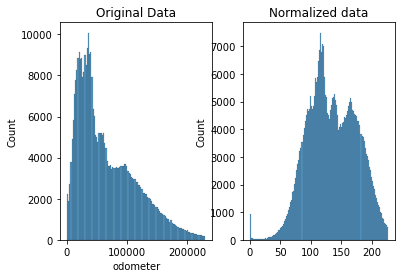

In [63]:
#Смотрю на нормальном распределения пробега 
normalised('odometer_normalised',quantitative['odometer'])

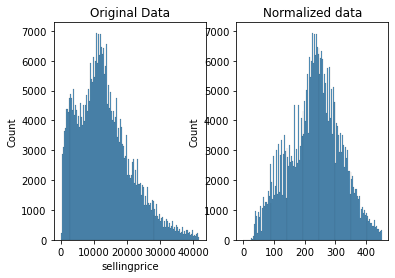

In [64]:
#Смотрю на нормальном распределения цены 
normalised('price_normalised', quantitative['sellingprice'])

In [65]:
#Нормализирую цену и пробег при помощи метода 'Box-Cox Transformation'
odometer_normalised = stats.boxcox(quantitative['odometer'])
price_normalised = stats.boxcox(quantitative['sellingprice'])

odometer_normalised = pd.Series(odometer_normalised[0])
price_normalised = pd.Series(price_normalised[0])

quantitative['odometer'] = odometer_normalised
quantitative['sellingprice'] = price_normalised



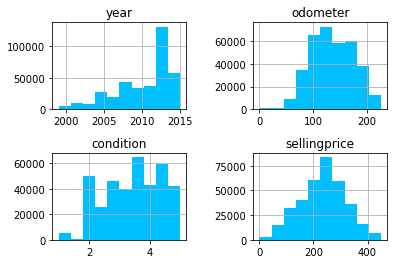

In [66]:
#Визуализирую снова
quantitative.hist(color = 'deepskyblue')
plt.subplots_adjust(wspace=0.5, hspace = 0.5)

Видно, что данные стали не идеальны, но гораздо ближе к нормальному распределению

In [67]:
quantitative.head()

,year,odometer,condition,sellingprice
0,2015,87.033101,5.0,319.894552
1,2015,70.457060,5.0,319.894552
2,2014,33.684011,4.5,379.705298
3,2015,82.268920,4.1,364.781448
5,2015,106.205175,1.0,213.362066


In [68]:
quantitative.describe()

,year,odometer,condition,sellingprice
count,376101.000000,352944.000000,376101.000000,352944.000000
mean,2010.093387,135.292981,3.424002,234.202283
std,3.667612,39.765728,0.946913,83.421481
min,1999.000000,0.000000,1.000000,0.000000
25%,2008.000000,106.245588,2.700000,179.310447
50%,2012.000000,133.156809,3.600000,237.885717
75%,2013.000000,166.789873,4.200000,290.251454
max,2015.000000,226.615669,5.000000,450.296370


У цены и у пробега появились значения, которые равны 0. Надо от них избавиться

In [69]:
#Фильтрую ненулевые значения
quantitative = quantitative[(quantitative['sellingprice'] > 0) & (quantitative['odometer'] > 0)]


In [70]:
quantitative.describe()

,year,odometer,condition,sellingprice
count,352109.000000,352109.000000,352109.000000,352109.000000
mean,2010.117830,135.613504,3.427256,234.543147
std,3.661919,39.263258,0.947284,83.179273
min,1999.000000,0.786365,1.000000,18.666238
25%,2008.000000,106.439801,2.700000,179.310447
50%,2012.000000,133.307192,3.600000,237.885717
75%,2013.000000,166.863639,4.200000,290.251454
max,2015.000000,226.615669,5.000000,450.296370


In [71]:
quantitative.head()

,year,odometer,condition,sellingprice
0,2015,87.033101,5.0,319.894552
1,2015,70.457060,5.0,319.894552
2,2014,33.684011,4.5,379.705298
3,2015,82.268920,4.1,364.781448
5,2015,106.205175,1.0,213.362066


In [72]:
#Пропущенных нет
quantitative.isnull().sum()

year            0
odometer        0
condition       0
sellingprice    0
dtype: int64

Теперь я хочу рассчитать корреляцию между различными факторами

In [73]:
linregress(quantitative['odometer'], quantitative['sellingprice'])

LinregressResult(slope=-1.486528574364595, intercept=436.1364962466931, rvalue=-0.7016886935421395, pvalue=0.0, stderr=0.002543702794992721)

Text(0, 0.5, 'Цена')

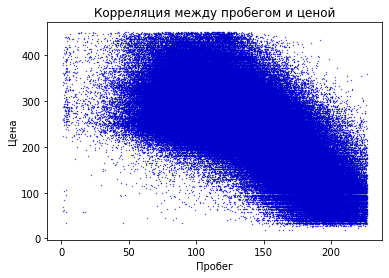

In [74]:
plt.scatter(quantitative['odometer'], quantitative['sellingprice'],s = 0.1, color = 'mediumblue')
plt.title('Корреляция между пробегом и ценой', size = 12)
plt.xlabel('Пробег')
plt.ylabel('Цена')


Обнаружена достаточно высокая отрциательная корреляция между пробегом и ценой, равная -0.7. Это означает, что чем выше пробег, тем ниже цена

In [75]:
scipy.stats.spearmanr(data1['odometer'], data1['year'])

SpearmanrResult(correlation=-0.8244017363225962, pvalue=0.0)

Также высокая отрицательная корреляция была найдена между пробегом и годом выпуска, что довольно логично. Это означает, что с увеличением пробега, уменьшается цена

In [76]:
scipy.stats.spearmanr(data1['condition'], data1['year'])

SpearmanrResult(correlation=0.5724418888729743, pvalue=0.0)

In [77]:
scipy.stats.spearmanr(data1['condition'], data1['sellingprice'])

SpearmanrResult(correlation=0.6302781556517542, pvalue=0.0)

Состояние авто коррелирует с ценой продажи и с годом выпуска, но не сильно. Коэффициент корреляции Спирмена показал среднее значение 

Далее я хочу посмотреть на то, сколько авто было продано в каждом году с 1982.

In [78]:
#Создаю дф, в котором группирую по году и считаю количество продаж
year_count = data1[data1['make']!='N'].groupby(['year'],as_index = False).condition.count()
year_count = year_count.rename(columns = {'condition': 'count'})

In [79]:
#Проверяю
year_count.year.unique()


array([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015], dtype=int64)

Все хорошо

Text(0.5, 0, 'Год')

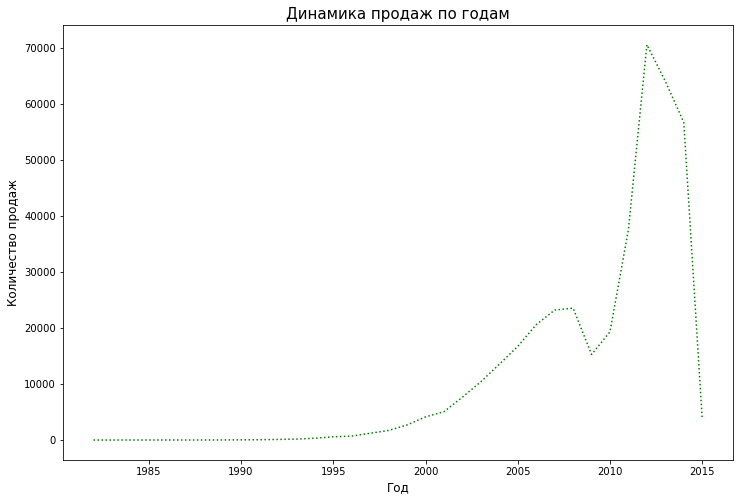

In [80]:
#Визуалзирую
fig = plt.figure()

fig.set_figheight(8)
fig.set_figwidth(12)
plt.plot(year_count['year'], year_count['count'],color = 'green', linestyle = ':')
plt.title(f"Динамика продаж по годам", size = 15)
plt.ylabel('Количество продаж', size = 12)
plt.xlabel('Год', size = 12)

Пиковые продажи были в 2012 году, после чего пошел спад. Интересно, что там было 

In [81]:
# решил немного оптимизировать процесс и написать функци по сзданию дф и графиков
def df_report(df_name, year,df_model, df_state, df_color):
    df_name = data1.copy()
    df_name = df_name[df_name['year'] == year]
    df_name = df_name.loc[:,['year', 'make', 'state_name', 'color']]
    
    df_model = df_name[df_name['make']!='n'].groupby(['make'],as_index = False).year.count().sort_values(by = 'year', ascending = False).head(10)
    df_state = df_name[df_name['state_name']!='n'].groupby(['state_name'],as_index = False).year.count().sort_values(by = 'year', ascending = False).head(10)
    df_color = df_name[df_name['color']!='N'].groupby(['color'],as_index = False).year.count().sort_values(by = 'year', ascending = False).head(10)
    
    fig = plt.figure()

    fig.set_figheight(5)
    fig.set_figwidth(7)

    ax1 = plt.subplot(2, 2, 1)
    plt.bar(df_model['make'], df_model['year'], color = 'steelblue')
    plt.xticks(rotation=90)
    plt.title(f'Количество проданных марок в {year} г.',fontsize = 10)


    ax2 = plt.subplot(2, 2, 2)
    plt.bar(df_color['color'], df_color['year'], color = 'lightslategrey')
    plt.xticks(rotation=90)
    plt.title(f'Самые распространенные цвета в {year} г.',fontsize = 10)


    ax1 = plt.subplot(2, 1, 2)
    plt.bar(df_state['state_name'], df_state['year'], color = 'teal')
    plt.xticks(rotation=90)
    plt.title(f'Штаты, в которых было больше всего продаж в {year} г.',fontsize = 10)
    plt.subplots_adjust(hspace=1, wspace = 0.5)

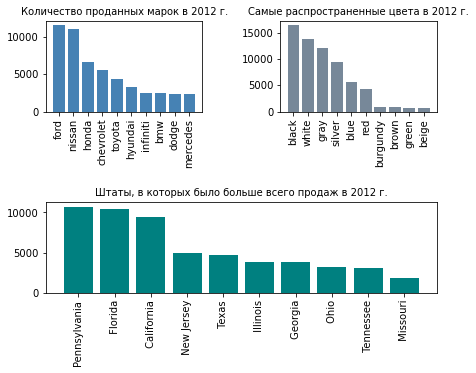

In [82]:
df_report('cars2012',2012,'model2012','state2012','color2012')


Исходя из этих данных, я не заметил ничего необычного. Например, Пенсильвания, Флорида и Калифорния являются самыми популярными штатами и в 2012 году, и в целом за все время. Примерно такая же ситуация обстоит и с автомобильными марками, однако в этом году самой популярным производителем стал "Ниссан", а не "Форд"

Для сравнения, можно взять 2010 год, т.к в это время наблюдалась просадка по продажам, а так же 2013 г, т.к в это время начался резкий спад после пика.

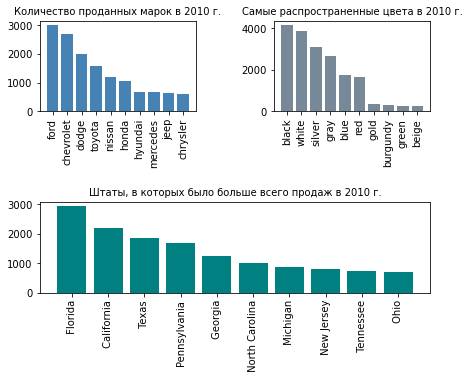

In [83]:
df_report('cars2010',2010,'model2010','state2010','color2010')

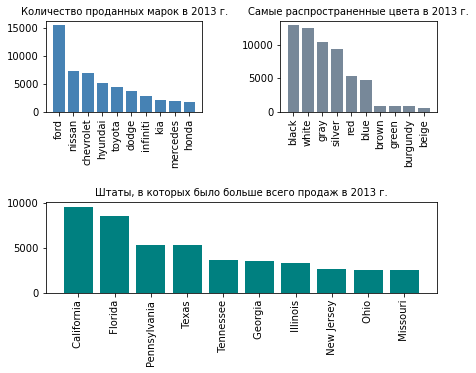

In [84]:
df_report('cars2013',2013,'model2013','state2013','color2013')

Анализ качественных данных не дал особых результатов. Спросом пользуются +- одни те же производители в одних и тех же штатах. Я думаю, что стоит проанализировать количественные показатели в этих годах. Для этого я хочу воспользоваться графиков "Ящик с усами"


In [85]:
def boxplot_price(year, year2):
    """ Создаю функцию, которая будет рисовать боксплоты по цене в разные года"""
    
    df_name = quantitative.copy()
    df_name = df_name[df_name['sellingprice'] > 0 ]
    df_name = df_name[df_name['year'] == year]
    df_name = df_name.sort_values(by = 'sellingprice')
    
    df_name2 = quantitative.copy()
    df_name2 = df_name2[df_name2['sellingprice'] > 0 ]
    df_name2 = df_name2[df_name2['year'] == year2]
    df_name2 = df_name2.sort_values(by = 'sellingprice')
    
    fig = plt.figure()

    fig.set_figheight(5)
    fig.set_figwidth(12)

    ax1 = plt.subplot(1, 2, 1)
    plt.boxplot(df_name['sellingprice'])
    plt.xticks(rotation=45)
    plt.title(f'Ящик с усами по цене в {year}')
    plt.ylabel('Цена')
    plt.grid()
    
    ax1 = plt.subplot(1, 2, 2)
    plt.boxplot(df_name2['sellingprice'])
    plt.xticks(rotation=45)
    plt.title(f'Ящик с усами по цене в {year2}')
    plt.ylabel('Цена')
    plt.grid()


   


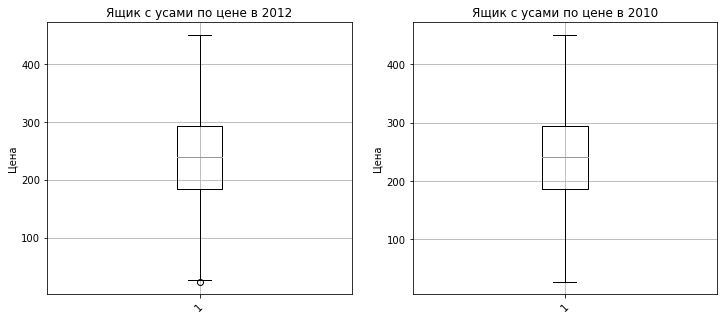

In [86]:
boxplot_price(2012, 2010)

Можно заметить, что различия по цене продаваемых автомобилей минимальны.

In [87]:
def boxplot_condition(year, year2):
    """ Создаю функцию, которая будет рисовать боксплоты по состоянию в разные года"""
    df_name = quantitative.copy()
    df_name = df_name[df_name['year'] == year]
    df_name = df_name.sort_values(by = 'condition')
    
    df_name2 = quantitative.copy()
    df_name2 = df_name2[df_name2['year'] == year2]
    df_name2 = df_name2.sort_values(by = 'condition')
    
    fig = plt.figure()

    fig.set_figheight(5)
    fig.set_figwidth(12)

    ax1 = plt.subplot(1, 2, 1)
    plt.boxplot(df_name['condition'])
    plt.xticks(rotation=45)
    plt.title(f'Ящик с усами по состоянию в {year} г.')
    plt.ylabel('Цена')
    plt.grid()
    
    ax1 = plt.subplot(1, 2, 2)
    plt.boxplot(df_name2['condition'])
    plt.xticks(rotation=45)
    plt.title(f'Ящик с усами по состоянию в {year2} г.')
    plt.ylabel('Цена')
    plt.grid()



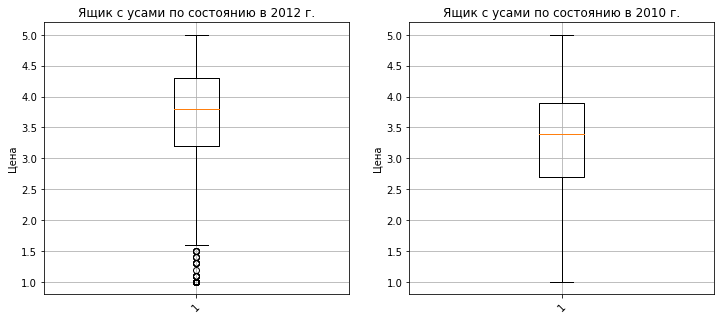

In [88]:
boxplot_condition(2012, 2010)

Исходя из этих диаграмм можно увидеть, что в пиковый год, американцы покупали более хорошие автомобили. Поэтому я считаю, что резкое повышение продаж связано с кризисом 2008 г. в Америке, который вызвал обвал авто рынка.

Подводя итоги хочется сказать, что американцы довольно большое внимание уделяют автомобилям, поэтому было весьма интересно проанализировать эти данные.

Можно сделать вывод, что предпочтения меняются в зависимости от штата, но по всей Америке люди любят отечественных производителей (Форд, Шевроле, Крайслер). 

Автомобильный рынок в США всегда был индикатором экономического здоровья страны, поэтому в кризис продажи резко падают, но с 1985 года видна тенденция устойчивого роста количества продаж. 

